In [1]:
import sys
import json
import typing as tp
from pathlib import Path

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from omegaconf import OmegaConf

In [2]:
outputs_dir = Path('.').resolve().parent.parent.parent / "outputs"
run_dir = outputs_dir / "2023-05-22/00-25-56"

In [19]:
def plot_labels_hist(labels: torch.Tensor, classes_num: int,
                     title: tp.Optional[str] = None, x_tick_interval: int = 10) -> None:
    unique_labels, labels_counts = labels.unique(return_counts=True)
    label_to_count = dict(zip(unique_labels.tolist(), labels_counts.tolist()))
    if classes_num is not None:
        label_to_count = {label: label_to_count.get(label, 0) for label in range(classes_num)}

    sns.barplot(x=list(label_to_count.keys()), y=list(label_to_count.values()))
    plt.xticks(range(0, classes_num, x_tick_interval), rotation=90)
    plt.xlabel("class ID")
    plt.ylabel("count")
    if title is not None:
        plt.title(title)

In [4]:
def hist_counts(labels: torch.Tensor, title: tp.Optional[str] = None) -> None:
    _, labels_counts = labels.unique(return_counts=True)
    sns.histplot(labels_counts)
    if title is not None:
        plt.title(title)

In [5]:
def load_train_preds(run_dir: Path) -> torch.Tensor:
    run_cfg = OmegaConf.load(run_dir / '.hydra' / 'config.yaml')
    image_outs = torch.load(run_cfg.cache.image_outs_path, map_location='cpu')
    _, image_preds = image_outs.max(dim=1)
    return image_preds

In [6]:
# hist_counts(test_labels, "test_labels")

In [7]:
def load_records(log_path: Path) -> tp.List[tp.Dict[str, tp.Any]]:
    with open(log_path) as f:
        return [json.loads(line.rstrip()) for line in f]

In [8]:
def load_log_records(*log_files_paths: Path, record_type: tp.Optional[str] = None) -> pd.DataFrame:
    files_records = []
    for log_file_path in log_files_paths:
        log_records = load_records(log_file_path)
        log_records = [record for record in log_records if record['message'] is None]
        if record_type is not None:
            log_records = [record for record in log_records if record.get('type') == record_type]
        files_records.extend(log_records)

    log_records_df = pd.json_normalize(files_records).drop(columns=['message', 'asctime'])
    return log_records_df

In [9]:
def load_cache_ids(run_dir: Path, cache_strategy: str, topk: int) -> torch.Tensor:
    log_df = load_log_records(run_dir / 'image_attention.log', record_type='cache_info')
    log_target = log_df['cache_strategy._target_'].apply(lambda strategy: strategy.split('.')[-1])
    log_topk = log_df['cache_strategy.topk']
    log_df = log_df[(log_target == cache_strategy) & (log_topk == topk)]
    cache_inds_path = log_df.iloc[0]['cache_inds_path']
    return torch.as_tensor(np.load(cache_inds_path))

In [10]:
def load_search_preds(run_dir: Path, cache_strategy: str, topk: tp.Optional[int], alpha: float, beta: float) -> torch.Tensor:
    log_df = load_log_records(run_dir / 'image_attention.log', record_type='searcher_result')
    log_target = log_df['cache_strategy._target_'].apply(lambda strategy: strategy.split('.')[-1])
    log_df = log_df[
        (log_target == cache_strategy) &
        (log_df['alpha'] == alpha) &
        (log_df['cache_weights_strategy.beta'] == beta)
    ]
    if topk is not None:
        log_df = log_df[log_df['cache_strategy.topk'] == topk]
    preds_path = log_df.iloc[0]['preds_path']
    return torch.as_tensor(np.load(preds_path))

In [11]:
def load_zero_shot_preds(run_dir: Path) -> torch.Tensor:
    log_df = load_log_records(run_dir / 'image_attention.log', record_type='zero_shot')
    preds_path = log_df.iloc[0]['preds_path']
    return torch.as_tensor(np.load(preds_path))

In [12]:
def set_up_fonts():
    sns.set_context("paper", rc={
        "font.size": 15,"axes.titlesize": 14,"axes.labelsize": 14,
        "legend.fontsize": 14, "legend.title_fontsize": 14,
        "xtick.labelsize": 14, "ytick.labelsize": 14
    })

In [16]:
def plot_cache_strategies(run_dir: Path, topk: int = 16, title: tp.Optional[str] = None):
    set_up_fonts()
    plt.figure(figsize=(15, 7))
    
    strategies = ['GlobalRandomSampleStrategy', 'TopKProbStrategy', 'PerPredClassRandomSampleStrategy']
    strategy_mapper = {
        'TopKProbStrategy': 'top_k',
        'PerPredClassRandomSampleStrategy': 'per_pred_random',
        'GlobalRandomSampleStrategy': 'global_random',
    }
    nrows, ncols = 2, len(strategies) + 1
    
    train_preds = load_train_preds(run_dir)
    train_labels = torch.as_tensor(np.load(run_dir / "gold_labels" / "cache_labels.npy"))
    classes_num = train_labels.unique().shape[0]

    plt.subplot(nrows, ncols, 1)
    plot_labels_hist(train_labels, classes_num, "gold: all_logits")

    for ind, strategy in enumerate(strategies):
        plt.subplot(nrows, ncols, ind + 2)
        cache_ids = load_cache_ids(run_dir, strategy, topk)
        plot_labels_hist(train_labels[cache_ids], classes_num, f'gold: {strategy_mapper[strategy]}')

    plt.subplot(nrows, ncols, ncols + 1)
    plot_labels_hist(train_preds, classes_num, "pred: all_logits")

    for ind, strategy in enumerate(strategies):
        plt.subplot(nrows, ncols, ind + ncols + 2)
        cache_ids = load_cache_ids(run_dir, strategy, topk)
        plot_labels_hist(train_preds[cache_ids], classes_num, f'pred: {strategy_mapper[strategy]}')

    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()

In [17]:
def plot_test_preds(run_dir: Path, topk: int = 16, alpha: float = 2.0, beta: float = 7.5, title: tp.Optional[str] = None):
    set_up_fonts()
    plt.figure(figsize=(24, 4))
    
    strategies = ['AllLogitsStrategy', 'GlobalRandomSampleStrategy', 'TopKProbStrategy', 'PerPredClassRandomSampleStrategy']
    strategy_mapper = {
        'AllLogitsStrategy': 'all_logits',
        'TopKProbStrategy': 'top_k',
        'PerPredClassRandomSampleStrategy': 'per_pred_random',
        'GlobalRandomSampleStrategy': 'global_random',
    }
    ncols = len(strategies) + 2
    
    test_labels = torch.as_tensor(np.load(run_dir / "gold_labels" / "test_labels.npy"))
    classes_num = test_labels.unique().shape[0]

    plt.subplot(1, ncols, 1)
    plot_labels_hist(test_labels, classes_num, "gold labels")

    plt.subplot(1, ncols, 2)
    zero_shot_preds = load_zero_shot_preds(run_dir)
    plot_labels_hist(zero_shot_preds, classes_num, "zero shot")

    for ind, strategy in enumerate(strategies):
        plt.subplot(1, ncols, ind + 3)
        strategy_topk = topk if strategy != 'AllLogitsStrategy' else None
        search_preds = load_search_preds(run_dir, strategy, strategy_topk, alpha, beta)
        plot_labels_hist(search_preds, classes_num, strategy_mapper[strategy])

    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()

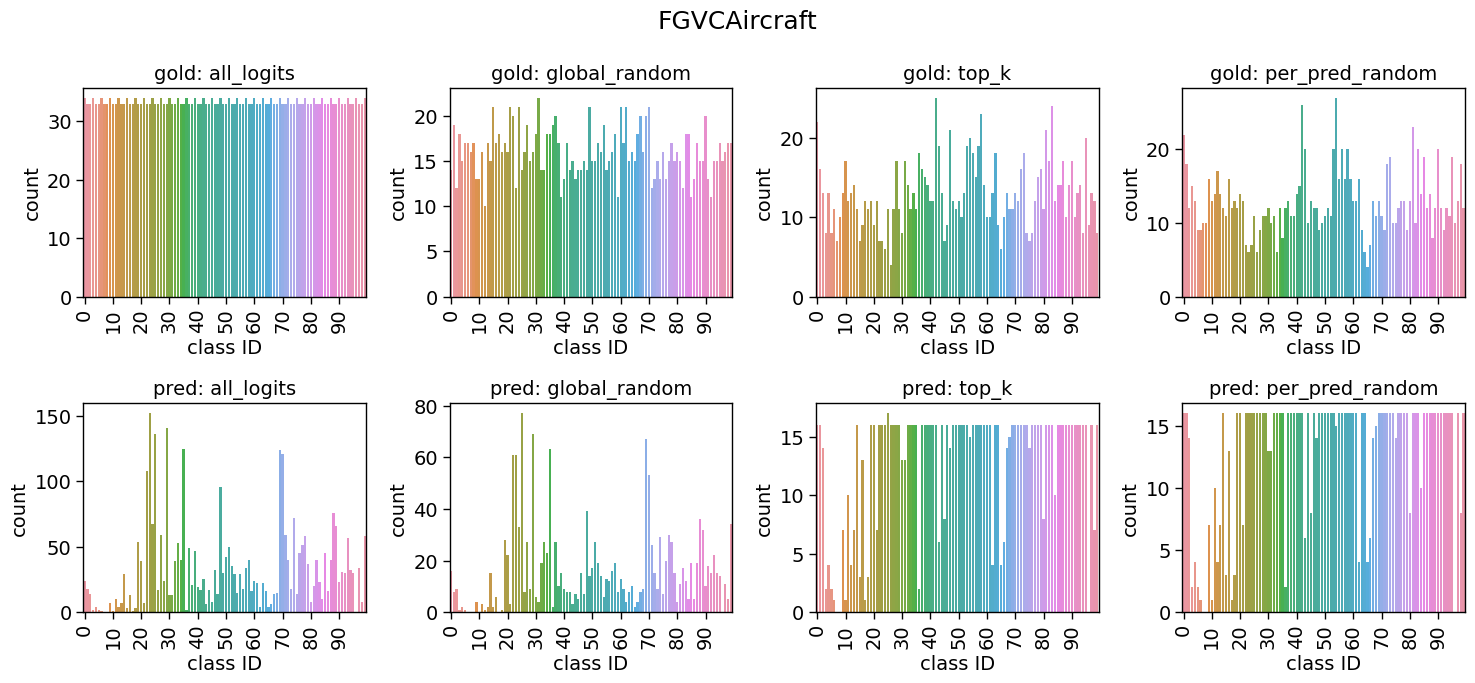

In [20]:
plot_cache_strategies(run_dir, title='FGVCAircraft')
plt.savefig('data/class_dist_3.pdf')

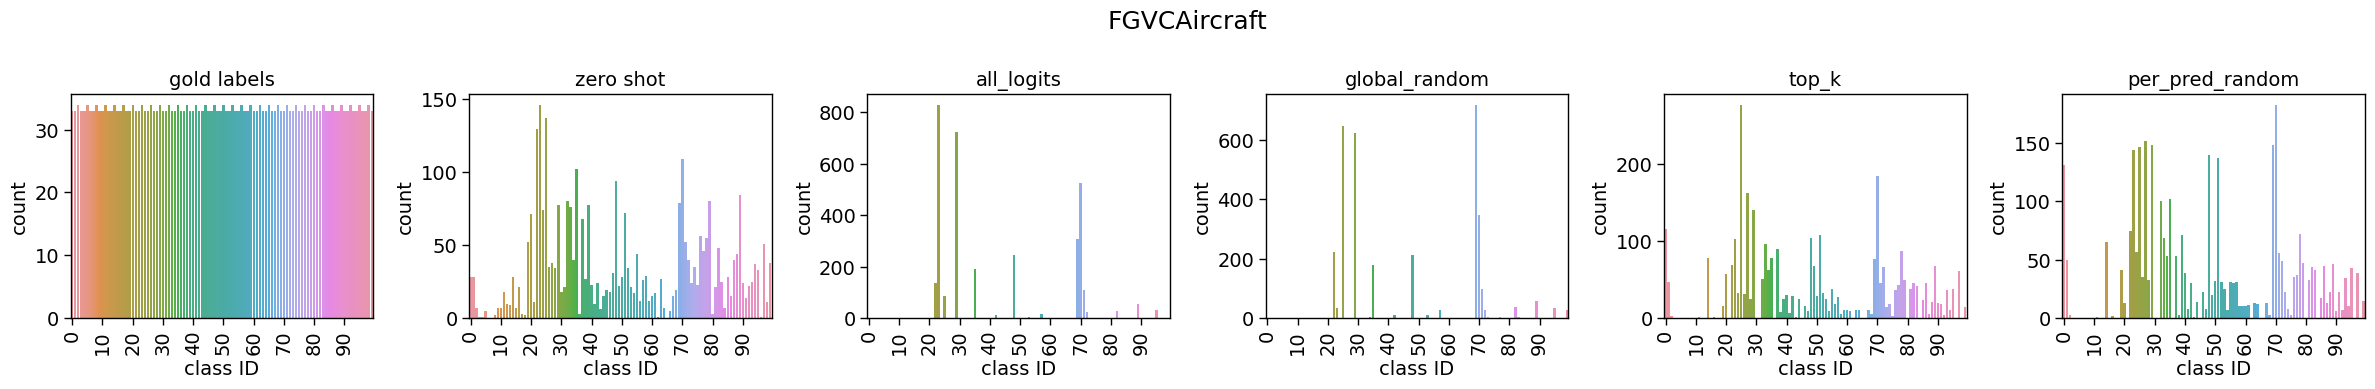

In [21]:
plot_test_preds(run_dir, title='FGVCAircraft')
plt.savefig('data/class_dist_4.pdf')